## Range / azimuth offset estimated from SAR

1. config_cuDenseOffsets.ipynb
2. offset_timeseries.ipynb

In [1]:
%matplotlib inline
import os
import pickle
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
plt.rcParams.update({'font.size': 12})
figsize = [12, 4]

proj_dir = '/Users/yunjunz/data/ChileSenAT149'
os.chdir(proj_dir)
print('Go to directory', proj_dir)

out_file = os.path.join(proj_dir, 'offset_comp/sar.pickle')
save = True

Go to directory /Users/yunjunz/data/ChileSenAT149


### 1. Read range / azimuth offset and save to pickle file

In [2]:
box4rg = (85, 25, 145, 70)    # box to read for range offset in (x0, y0, x1, y1)
box4az = None                 # box to read for azimuth offset

# required files
ts_files = [os.path.join(proj_dir, 'mintpyOffset/timeseriesRg.h5'),
            os.path.join(proj_dir, 'mintpyOffset/timeseriesAz.h5')]
mask_file = os.path.join(proj_dir, 'mintpyOffset/maskTempCoh.h5')
mask_swath1_file = os.path.join(proj_dir, 'mintpyOffset/maskTempCohSwath1.h5')

ts_obj = timeseries(ts_files[0])
ts_obj.open(print_msg=False)
num_date = ts_obj.numDate

# output
sar = {}
sar['date'] = np.array(ts_obj.dateList)
sar['time'] = np.array(ts_obj.times)

##----- 1. range
# read data
print('read data from file: {}'.format(ts_files[0]))
mask = readfile.read(mask_file, box=box4rg)[0].flatten()
ts_data = readfile.read(ts_files[0], box=box4rg)[0].reshape(num_date, -1)
ts_data -= ts_data[0,:]          # reference to the first date
ts_data[:, mask==0] = np.nan     # mask invalid pixels

# calculate median and mean
sar['range_offset_med'] = np.nanmedian(ts_data, axis=-1)
sar['range_offset_mad'] = ut.median_abs_deviation(ts_data, axis=-1)
sar['range_offset_avg'] = np.nanmean(ts_data, axis=-1)
sar['range_offset_std'] = np.nanstd(ts_data, axis=-1)

##----- 2. azimuth
# read data
print('read data from file: {}'.format(ts_files[1]))
mask = readfile.read(mask_file, box=box4az)[0].flatten()
ts_data = readfile.read(ts_files[1], box=box4az)[0].reshape(num_date, -1)
ts_data -= ts_data[0,:]          # reference to the first date
ts_data[:, mask==0] = np.nan     # mask invalid pixels

# use swath 1 only for dates with IPF from 2.60 to 2.70, which has focusing artifacts
mask_swath1 = readfile.read(mask_swath1_file, box=box4az)[0].flatten()
IPFs = [float(i) for i in ts_obj.metadata['SENTINEL1_IPF'].split()]
for i in range(num_date):
    if 2.60 <= IPFs[i] <= 2.70:
        ts_data[i, mask_swath1==0] = np.nan

# calculate median and mean
sar['azimuth_offset_med'] = np.nanmedian(ts_data, axis=-1)
sar['azimuth_offset_mad'] = ut.median_abs_deviation(ts_data, axis=-1)
sar['azimuth_offset_avg'] = np.nanmean(ts_data, axis=-1)
sar['azimuth_offset_std'] = np.nanstd(ts_data, axis=-1)

## save off dict to pickle file
with open(out_file, 'wb') as f:
    pickle.dump(sar, f)
    print('save data to file: {}'.format(out_file))

read data from file: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/timeseriesRg.h5
read data from file: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/timeseriesAz.h5
save data to file: /Users/yunjunz/data/ChileSenAT149/offset_comp/sar.pickle


### 2. plot

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/TS_sar_azimuth.png


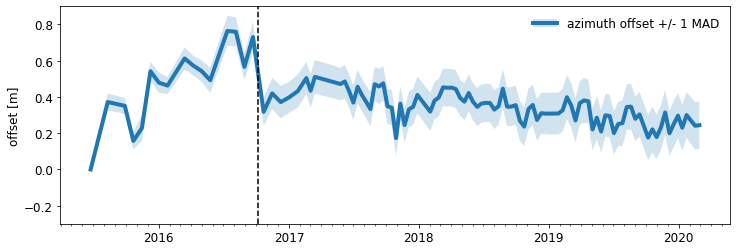

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/TS_sar_range.png


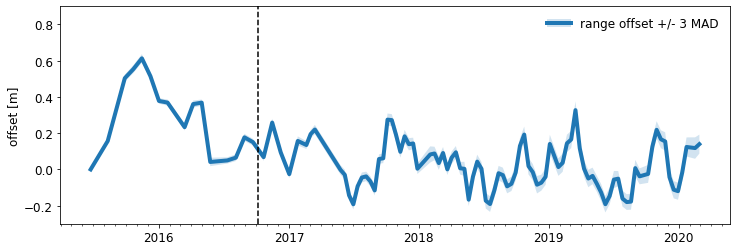

In [3]:
for key, n in zip(['azimuth', 'range'], [1, 3]):
    x = sar['time']
    y = sar['{}_offset_med'.format(key)]
    y_err = sar['{}_offset_mad'.format(key)] * n

    fig, ax = plt.subplots(figsize=figsize)
    p0, = ax.plot(x, y, linewidth=4, color='C0')
    p1  = ax.fill_between(x, y - y_err, y + y_err, fc='C0', ec='none', alpha=0.2)

    # axis format
    ax.axvline(x=dt(2016, 10, 7), linestyle='--', color='k')   # S1A / S1B
    pp.auto_adjust_xaxis_date(ax, x, every_year=1, buffer_year=None)
    ax.set_ylabel('offset [m]')
    ax.set_ylim(-0.3, 0.9)
    ax.legend([(p0, p1)], ['{} offset +/- {} MAD'.format(key, n)], frameon=False)

    # output
    out_fig = os.path.join(os.path.dirname(out_file), 'TS_sar_{}.png'.format(key))
    print('save figure to file', out_fig)
    if save:
        plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()